In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

import pmdarima as pm


In [105]:
url = "https://storage.googleapis.com/safetymap/preprocessed_data2.csv"
df = pd.read_csv(url)
df.drop(columns = "colonia_id", inplace = True)

In [303]:
df

,alcaldia_colonia,año_mes_hecho,burglary,danger of well-being,domestic violence,fraud,homicide,property damage,robbery with violence,robbery without violence,sexual crime,threats
0,ALVARO OBREGON || 16 DE SEPTIEMBRE,2019-01-01,0,0,0,0,0,0,0,0,0,0
1,ALVARO OBREGON || 16 DE SEPTIEMBRE,2019-02-01,0,0,0,0,0,0,0,0,0,0
2,ALVARO OBREGON || 16 DE SEPTIEMBRE,2019-03-01,0,0,0,0,0,0,0,0,0,0
3,ALVARO OBREGON || 16 DE SEPTIEMBRE,2019-04-01,0,0,0,0,0,0,0,0,0,0
4,ALVARO OBREGON || 16 DE SEPTIEMBRE,2019-05-01,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
104086,XOCHIMILCO || XICALHUACAN,2022-11-01,1,0,0,0,0,0,0,0,0,1
104087,XOCHIMILCO || XICALHUACAN,2022-12-01,0,0,0,0,0,0,0,1,0,1
104088,XOCHIMILCO || XICALHUACAN,2023-01-01,0,1,1,0,0,1,0,0,0,1
104089,XOCHIMILCO || XICALHUACAN,2023-02-01,0,0,0,0,0,0,0,0,0,0


In [301]:
df.alcaldia_colonia.unique().shape

(2041,)

In [355]:
nom_delitos = df.columns[2:]

In [358]:
nom_colonias = df.alcaldia_colonia.unique()

In [400]:
pre_data = df.set_index(["año_mes_hecho","alcaldia_colonia"]).unstack("alcaldia_colonia")

## train test split

In [108]:
group = df.groupby("año_mes_hecho")["burglary"].count()
group.pipe(lambda x: x.cumsum()/x.sum()*100)

año_mes_hecho
2019-01-01      1.960784
2019-02-01      3.921569
2019-03-01      5.882353
2019-04-01      7.843137
2019-05-01      9.803922
2019-06-01     11.764706
2019-07-01     13.725490
2019-08-01     15.686275
2019-09-01     17.647059
2019-10-01     19.607843
2019-11-01     21.568627
2019-12-01     23.529412
2020-01-01     25.490196
2020-02-01     27.450980
2020-03-01     29.411765
2020-04-01     31.372549
2020-05-01     33.333333
2020-06-01     35.294118
2020-07-01     37.254902
2020-08-01     39.215686
2020-09-01     41.176471
2020-10-01     43.137255
2020-11-01     45.098039
2020-12-01     47.058824
2021-01-01     49.019608
2021-02-01     50.980392
2021-03-01     52.941176
2021-04-01     54.901961
2021-05-01     56.862745
2021-06-01     58.823529
2021-07-01     60.784314
2021-08-01     62.745098
2021-09-01     64.705882
2021-10-01     66.666667
2021-11-01     68.627451
2021-12-01     70.588235
2022-01-01     72.549020
2022-02-01     74.509804
2022-03-01     76.470588
2022-04-01 

In [109]:
INPUT_LENGTH = 1 * 12 # records every 1 month x 12 months per year = 12 months

In [110]:
TRAIN_TEST_RATIO = 0.70

In [111]:
import pandas as pd
from typing import Tuple

def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on 
    the split ratio.
    - df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    - df_test should contain all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """
    fold_train = fold[0:round(len(fold)*train_test_ratio)]
    fold_test = fold[(round(len(fold)*train_test_ratio - input_length)):]
    return fold_train,fold_test

In [245]:
(fold_train, fold_test) = train_test_split(pre_data, TRAIN_TEST_RATIO, INPUT_LENGTH)

## converting to X_train, y_train and X_test, y_test

(36, 20410)

In [246]:
print(df.columns)

Index(['alcaldia_colonia', 'año_mes_hecho', 'burglary', 'danger of well-being',
       'domestic violence', 'fraud', 'homicide', 'property damage',
       'robbery with violence', 'robbery without violence', 'sexual crime',
       'threats'],
      dtype='object')


In [247]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, 
    sequence_stride: int) -> Tuple[np.array]:
    """slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence

    Args:
        fold (pd.DataFrame): One single fold dataframe
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i
        sequence_stride (int): How many timesteps to take before taking the next X_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i_transformed = fold.iloc[i:i + input_length, :]
        y_i_transformed = fold.iloc[i + input_length:i + input_length + output_length, :][TARGET]


        fold_train_list = X_i_transformed.stack("alcaldia_colonia").groupby(["alcaldia_colonia", "año_mes_hecho"])\
                            .apply(lambda x: x.values.tolist()[0])\
                            .groupby("alcaldia_colonia").apply(lambda x: x.values.tolist())\
                            .tolist()

        fold_test_list = y_i_transformed.stack("alcaldia_colonia").groupby(["alcaldia_colonia", "año_mes_hecho"])\
                            .apply(lambda x: x.values.tolist()[0])\
                            .groupby("alcaldia_colonia").apply(lambda x: x.values.tolist())\
                            .tolist()

    return (np.array(fold_train_list), np.array(fold_test_list))

In [279]:
SEQUENCE_STRIDE = 1
OUTPUT_LENGTH = 12
TARGET = ['burglary', 'danger of well-being',
       'domestic violence', 'fraud', 'homicide', 'property damage',
       'robbery with violence', 'robbery without violence', 'sexual crime',
       'threats']

In [280]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)


In [281]:
X_train.shape

(2041, 12, 10)

In [282]:
y_train.shape

(2041, 12, 10)

In [374]:
fold_test

burglary  \
alcaldia_colonia ALVARO OBREGON || 16 DE SEPTIEMBRE   
año_mes_hecho                                         
2021-01-01                                        0   
2021-02-01                                        0   
2021-03-01                                        0   
2021-04-01                                        0   
2021-05-01                                        0   
2021-06-01                                        0   
2021-07-01                                        0   
2021-08-01                                        0   
2021-09-01                                        0   
2021-10-01                                        0   
2021-11-01                                        0   
2021-12-01                                        0   
2022-01-01                                        0   
2022-02-01                                        0   
2022-03-01                                        0   
2022-04-01                                        0   
2022-05-01                                        0   
2022-06-01                                        0   
2022-07-01                                        0   
2022-08-01                                        0   
2022-09-01                                        0   
2022-10-01                                        0   
2022-11-01                                        0   
2022-12-01                                        0   
2023-01-01                                        0   
2023-02-01                                        0   
2023-03-01                                        0   

                                                                              \
alcaldia_colonia ALVARO OBREGON || 19 DE MAYO ALVARO OBREGON || 1RA VICTORIA   
año_mes_hecho                                                                  
2021-01-01                                  1                              0   
2021-02-01                                  0                              0   
2021-03-01                                  0                              0   
2021-04-01                                  0                              0   
2021-05-01                                  0                              0   
2021-06-01                                  0                              0   
2021-07-01                                  0                              0   
2021-08-01                                  0                              1   
2021-09-01                                  0                              0   
2021-10-01                                  0                              0   
2021-11-01                                  1                              0   
2021-12-01                                  0                              0   
2022-01-01                                  1                              0   
2022-02-01                                  0                              0   
2022-03-01                                  0                              0   
2022-04-01                                  0                              0   
2022-05-01                                  0                              0   
2022-06-01                                  0                              0   
2022-07-01                                  0                              0   
2022-08-01                                  0                              0   
2022-09-01                                  0                              0   
2022-10-01                                  0                              0   
2022-11-01                                  0                              0   
2022-12-01                                  0                              0   
2023-01-01                                  0                              0   
2023-02-01                                  0                              0   
2023-03-01                                  0                           

## Model

In [284]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization

def init_model(X_train, y_train):
    model = Sequential()
    #normalizer = Normalization() # Instantiate a "normalizer" layer
    #normalizer.adapt(X_train) # "Fit" it on the train set
    
    # –– Model
    #model.add(normalizer)
    model.add(layers.Masking(mask_value=-1, input_shape=(12,10)))
    model.add(layers.LSTM(units=40, activation='tanh', return_sequences =True))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(rate=0.2))  # The rate is the percentage of neurons that are "killed"
    model.add(layers.Dense(10, activation='relu'))

    # –– Compilation
    model.compile(loss='mse', 
                  optimizer='adam',
                 metrics = ["mae"]) 

    return model 

In [285]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10)

model = init_model(X_train, y_train)
model.summary()
history = model.fit(X_train, y_train, 
          epochs=200, 
          batch_size=32, 
          verbose=1, 
          callbacks = [es],
          validation_split=0.2)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_38 (Masking)        (None, 12, 10)            0         
                                                                 
 lstm_37 (LSTM)              (None, 12, 40)            8160      
                                                                 
 dense_83 (Dense)            (None, 12, 50)            2050      
                                                                 
 dropout_38 (Dropout)        (None, 12, 50)            0         
                                                                 
 dense_84 (Dense)            (None, 12, 10)            510       
                                                                 
Total params: 10720 (41.88 KB)
Trainable params: 10720 (41.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
51/51

In [286]:
model.evaluate(X_test,y_test)

64/64 [==============================] - 0s 772us/step - loss: 1.6284 - mae: 0.6537


[1.6284325122833252, 0.6536749005317688]

In [287]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

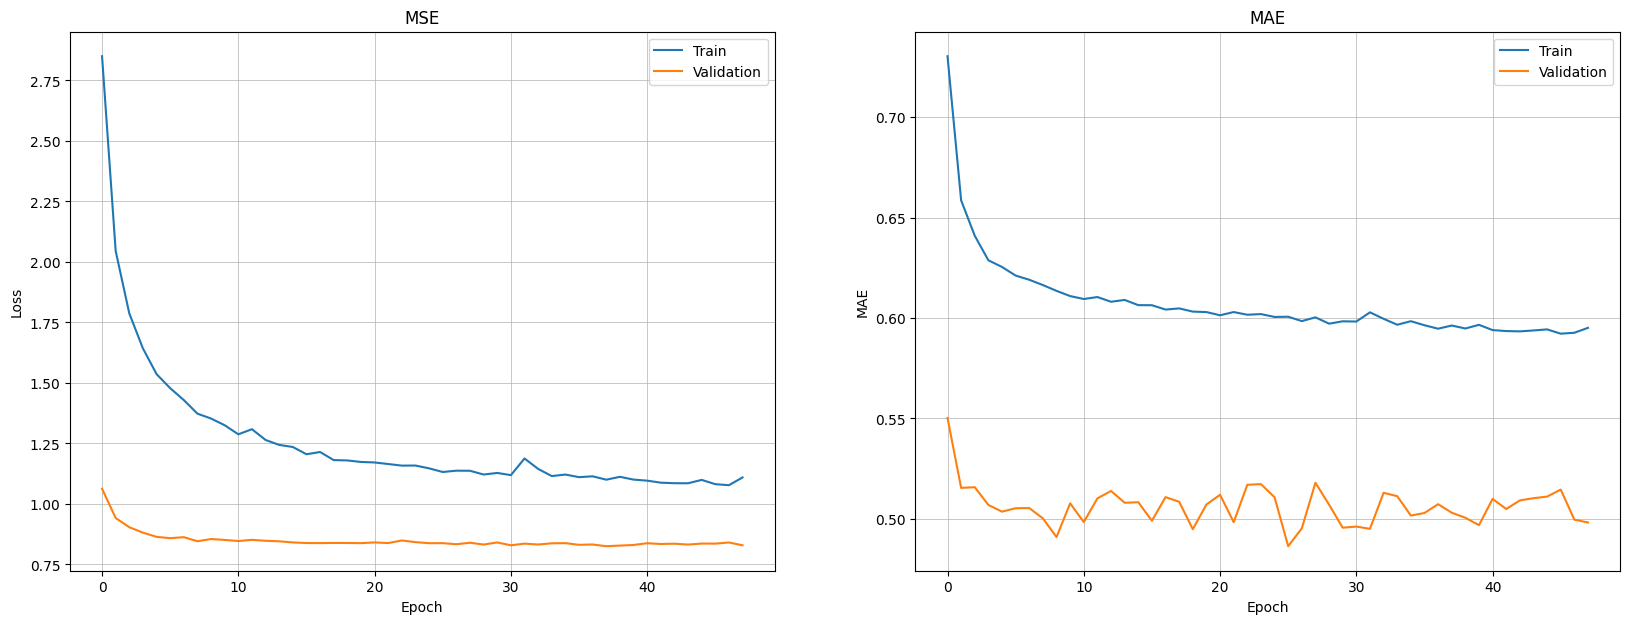

In [288]:
plot_history(history)

In [289]:
predictions = model.predict(X_test)

64/64 [==============================] - 0s 791us/step


In [373]:
X_test.shape

(2041, 12, 10)

In [372]:
i = 0
predictions.shape

(2041, 12, 10)

In [326]:
pd.DataFrame(predictions[:, i, :])

,0,1,2,3,4,5,6,7,8,9
0,0.068136,0.070341,0.223254,0.140307,0.026460,0.040123,0.080042,0.147989,0.027177,0.107545
1,0.068136,0.070341,0.223254,0.140307,0.026460,0.040123,0.080042,0.147989,0.027177,0.107545
2,0.280759,0.485200,0.956357,1.828380,0.067505,0.350372,0.824612,1.557077,0.217093,0.663390
3,0.360039,0.498954,1.805623,0.703487,0.106816,0.315875,0.700245,0.764741,0.277799,0.773659
4,0.068136,0.070341,0.223254,0.140307,0.026460,0.040123,0.080042,0.147989,0.027177,0.107545
...,...,...,...,...,...,...,...,...,...,...
2036,0.164526,0.215876,0.615632,0.474052,0.051795,0.152937,0.326442,0.438752,0.110306,0.344567
2037,0.068136,0.070341,0.223254,0.140307,0.026460,0.040123,0.080042,0.147989,0.027177,0.107545
2038,0.068136,0.070341,0.223254,0.140307,0.026460,0.040123,0.080042,0.147989,0.027177,0.107545
2039,0.993354,2.203834,4.159700,3.500302,0.501947,0.993848,2.502710,3.670076,0.831739,2.796137


In [382]:
start_date = '2023-01-01'
num_periods = 12

date_range = pd.date_range(start=start_date, periods=num_periods, freq='MS')
date_series = pd.Series(range(num_periods), index=date_range)

print(date_series)


2023-01-01     0
2023-02-01     1
2023-03-01     2
2023-04-01     3
2023-05-01     4
2023-06-01     5
2023-07-01     6
2023-08-01     7
2023-09-01     8
2023-10-01     9
2023-11-01    10
2023-12-01    11
Freq: MS, dtype: int64


In [390]:
date_series.index[0].date()

datetime.date(2023, 1, 1)

In [393]:
p2 = []

for period in range(predictions.shape[1]):
    p2.append(pd.DataFrame(predictions[:, period, :], columns =nom_delitos, index = nom_colonias).assign(periodo= date_series.index[period].date()))

new_prediction = pd.concat(p2)

In [399]:
new_prediction.set_index("periodo",append=True).round(0).astype(int)

,,burglary,danger of well-being,domestic violence,fraud,homicide,property damage,robbery with violence,robbery without violence,sexual crime,threats
,periodo,,,,,,,,,,
ALVARO OBREGON || 16 DE SEPTIEMBRE,2023-01-01,0,0,0,0,0,0,0,0,0,0
ALVARO OBREGON || 19 DE MAYO,2023-01-01,0,0,0,0,0,0,0,0,0,0
ALVARO OBREGON || 1RA VICTORIA,2023-01-01,0,0,1,2,0,0,1,2,0,1
ALVARO OBREGON || 1RA VICTORIA SECCION BOSQUES,2023-01-01,0,0,2,1,0,0,1,1,0,1
ALVARO OBREGON || 26 DE JULIO,2023-01-01,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
XOCHIMILCO || VILLA XOCHIMILCO (U HAB),2023-12-01,0,0,0,0,0,0,0,0,0,0
XOCHIMILCO || VILLAS DE LOS TRABAJADORES (GDF) (U HAB),2023-12-01,0,0,0,0,0,0,0,0,0,0
XOCHIMILCO || VIVEROS DE COACTETLAN,2023-12-01,0,0,0,0,0,0,0,0,0,0
